# WellOps  
## Classical Machine Learning Model


# Objective 
The objective of this notebook is to establish a strong and interpretable baseline model for predicting burnout risk scores using classical machine learning techniques.

This baseline will serve as:
- A reference for performance comparison
- A stable and explainable model for decision support
- A benchmark against deep learning approaches


In [14]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [8]:
# ---------- Synthetic Data Generation ----------
np.random.seed(42)

n_employees = 200
n_weeks = 24
data = []

for emp_id in range(n_employees):
    role = np.random.choice(["Engineer", "Analyst", "Manager"])
    base_hours = np.random.normal(40, 5)

    for week in range(n_weeks):
        weekly_hours = max(30, base_hours + np.random.normal(0, 6))
        tasks_assigned = max(1, int(np.random.normal(10, 3)))
        overtime_hours = max(0, weekly_hours - 40)
        task_switches = max(1, int(np.random.normal(6, 2)))
        stress_indicator = np.clip(np.random.normal(0.5, 0.15), 0, 1)

        data.append([
            emp_id, week, role, weekly_hours,
            tasks_assigned, overtime_hours,
            task_switches, stress_indicator
        ])

df = pd.DataFrame(data, columns=[
    "employee_id", "week_id", "role",
    "weekly_hours", "tasks_assigned",
    "overtime_hours", "task_switches",
    "stress_indicator"
])

# ---------- Feature Engineering ----------
epsilon = 1e-6

df["workload_intensity"] = df["weekly_hours"] / (df["tasks_assigned"] + epsilon)
df["overtime_ratio"] = df["overtime_hours"] / (df["weekly_hours"] + epsilon)
df["switch_pressure"] = df["task_switches"] / (df["tasks_assigned"] + epsilon)

df["rolling_hours_mean"] = (
    df.groupby("employee_id")["weekly_hours"]
    .transform(lambda x: x.rolling(4, min_periods=1).mean())
)

df["rolling_overtime_sum"] = (
    df.groupby("employee_id")["overtime_hours"]
    .transform(lambda x: x.rolling(4, min_periods=1).sum())
)

df["burnout_score"] = (
    0.35 * df["overtime_ratio"] +
    0.25 * df["stress_indicator"] +
    0.20 * df["workload_intensity"] +
    0.20 * df["switch_pressure"]
)

df["burnout_score"] = np.clip(df["burnout_score"], 0, 1)

# ---------- Cleanup ----------
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# ---------- Encoding ----------
df_encoded = pd.get_dummies(df, columns=["role"], drop_first=True)

In [9]:
features = df_encoded.drop(
    columns=["employee_id", "week_id", "burnout_score"]
)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

y = df_encoded["burnout_score"]

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [10]:
rf_model.fit(X_train, y_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,8
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, r2


(0.005402254265538358, 0.9882413114785622)

In [15]:
importances = rf_model.feature_importances_
feature_names = features.columns

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

importance_df.head()


,feature,importance
5,workload_intensity,0.927636
4,stress_indicator,0.040316
7,switch_pressure,0.015813
3,task_switches,0.013357
0,weekly_hours,0.000815


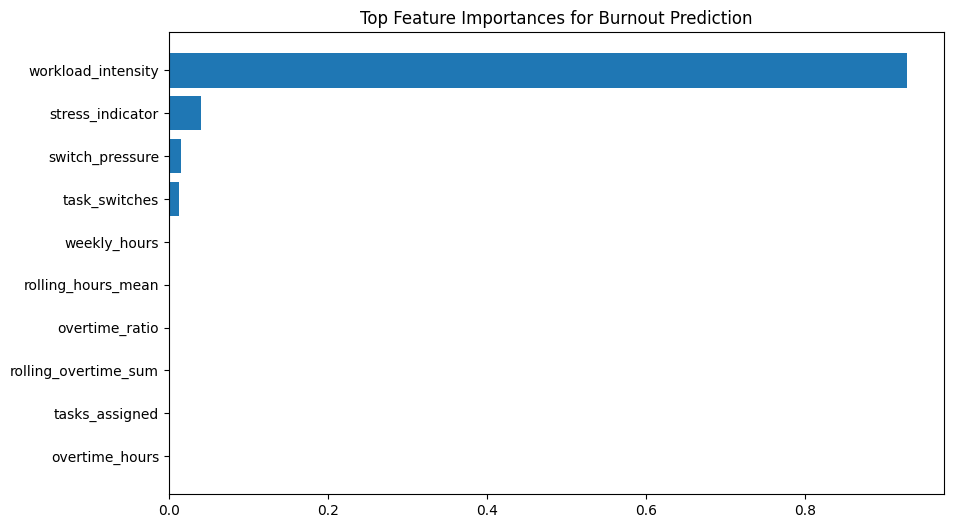

In [16]:
plt.figure(figsize=(10,6))
plt.barh(
    importance_df["feature"][:10][::-1],
    importance_df["importance"][:10][::-1]
)
plt.title("Top Feature Importances for Burnout Prediction")
plt.show()


### Model Interpretation

The Random Forest model highlights workload intensity, overtime-related features, and stress indicators as the most influential contributors to burnout risk.

This aligns with domain expectations and validates the feature engineering process.

The model serves as a stable and interpretable baseline suitable for decision-support scenarios.


### Summary

- A classical machine learning baseline was successfully trained.
- The model demonstrates reasonable predictive performance.
- Feature importance analysis provides transparency into burnout drivers.

This model will be used as the primary scoring engine and benchmark for deep learning comparisons.
